In [1]:
import numpy as np
import pandas as pd
import xarray as xr


import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset


In [2]:
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/research/data/REPPU/pbig5min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30,80)
reppu_data.shape

(45792, 30, 80)

In [3]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [4]:
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset>
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 2021-05-10 ... 2022-07-31T23:55:00
  * lat        (lat) float64 53.1 54.36 55.62 56.89 ... 85.91 87.18 88.44 89.7
  * lon        (lon) float64 1.6 6.106 10.61 15.12 ... 344.1 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 0.6909 0.507 0.3146 ... -22.67 -22.71

In [81]:
omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs
omni_df

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')
reppu_omni_ds = reppu_omni_ds.sel(dt=slice('2022-06-12', '2022-07-31'))
reppu_omni_ds

<xarray.Dataset>
Dimensions:         (dt: 14400, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2022-06-12 ... 2022-07-31T23:55:00
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 3.867 3.512 3.124 ... -22.67 -22.71
    BY_GSE          (dt) float64 5.56 6.27 6.27 5.13 ... -9.29 -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 4.37 3.15 3.15 4.46 ... -0.53 -0.74 -4.03 -4.71
    flow_speed      (dt) float64 374.0 378.0 378.0 370.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 9.69 9.82 9.82 10.64 ... 7.12 8.03 7.08 6.84
    tilt_angle      (dt) float64 0.3538 0.3472 0.3472 ... 0.2778 0.2744 0.271

In [82]:
train_slice = slice(0, 11520) #40days * 288 = 11520
test_slice = slice(11520, None) #10 days * 288 = 2880 

# Define the slice ranges for train and test data
#train_slice = slice(0, 36576) #36576 / 24 / 12 = 127 days = 80% of the data
t#est_slice = slice(36576, None) # 9216 / 24 / 12 = 32 days = 20% of the data

ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

X_train = ds_train.drop_vars('potential').to_array().values.T
y_train = ds_train['potential'].values
y_train = y_train.reshape(-1, 30*80)
#y_train = np.mean(y_train, axis=1)

X_test = ds_test.drop_vars('potential').to_array().values.T
y_test = ds_test['potential'].values
y_test = y_test.reshape(-1, 30*80)
#y_test = np.mean(y_test, axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11520, 5), (11520, 2400), (2880, 5), (2880, 2400))

In [83]:
# Normalizing the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [84]:
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [85]:
X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([11520, 5]),
 torch.Size([11520, 2400]),
 torch.Size([2880, 5]),
 torch.Size([2880, 2400]))

In [86]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Remove extra dimensions from output
        out = self.fc(out[:, -1, :].squeeze())  # Squeeze the output
        return out


In [36]:
sequence_length = 1

# Instantiate the LSTM model with updated input_size
input_size = X_train_tensor.shape[1]
hidden_size = 64
num_layers = 2
output_size = y_train_tensor.shape[1]
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 1
for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), sequence_length):
        inputs = X_train_tensor[i:i+sequence_length]
        targets = y_train_tensor[i+sequence_length-1]
        # Forward pass
        outputs = model(inputs.unsqueeze(0)) # Add batch dimension
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #if (epoch+1) % 10 == 0:
    rmse = np.sqrt(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.2f}, RMSE: {rmse:.2f} V')


Epoch [1/1], Loss: 68.31, RMSE: 8.26 V


In [65]:
def dummy_slider():
    #THis is a handy visualisation tool for testing
    # it has no bearing on the actual training
    x = np.arange(0, 60)
    seq_len = 12
    slider = 12

    for i in range(0, len(x) - seq_len + 1, slider):
        inputs = x[i:i + seq_len]
        targets = x[i + seq_len - 1]
        print(f'inputs: {inputs}, targets: {targets}')

dummy_slider()

inputs: [ 0  1  2  3  4  5  6  7  8  9 10 11], targets: 11
inputs: [12 13 14 15 16 17 18 19 20 21 22 23], targets: 23
inputs: [24 25 26 27 28 29 30 31 32 33 34 35], targets: 35
inputs: [36 37 38 39 40 41 42 43 44 45 46 47], targets: 47
inputs: [48 49 50 51 52 53 54 55 56 57 58 59], targets: 59


In [77]:
seq_len = 12
slider = 8

# Instantiate the LSTM model with updated input_size
input_size = X_train_tensor.shape[1]
hidden_size = 64
num_layers = 2
output_size = y_train_tensor.shape[1]
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 1
for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor) - seq_len + 1, slider):
        inputs = X_train_tensor[i:i + seq_len]
        targets = y_train_tensor[i + seq_len - 1]
        # Forward pass
        outputs = model(inputs.unsqueeze(0)) # Add batch dimension
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    rmse = np.sqrt(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.2f}, RMSE: {rmse:.2f} V')


Epoch [1/1], Loss: 12.53, RMSE: 3.54 V


In [78]:
model.eval()

predicted = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor) - seq_len + 1, slider):
        inputs = X_test_tensor[i:i + seq_len]
        outputs = model(inputs.unsqueeze(0))
        predicted.append(outputs)

predicted = torch.cat(predicted, dim=0)

In [79]:
predicted.reshape(-1, 30, 80).shape

torch.Size([4283, 30, 80])

In [70]:
reshaped_predicted = predicted.reshape(-1, 30, 80).numpy()

In [71]:
lat = np.linspace(53.1, 89.7, 30)
lon = np.linspace(1.6, 357.6, 80)
potential = reshaped_predicted[0]

ds_predicted = xr.Dataset({'potential': (['lat', 'lon'], potential)},
                            coords={'lat': lat, 'lon': lon})

ds_predicted

<xarray.Dataset>
Dimensions:    (lat: 30, lon: 80)
Coordinates:
  * lat        (lat) float64 53.1 54.36 55.62 56.89 ... 85.91 87.18 88.44 89.7
  * lon        (lon) float64 1.6 6.106 10.61 15.12 ... 344.1 348.6 353.1 357.6
Data variables:
    potential  (lat, lon) float32 1.023 0.8097 0.592 ... 5.366 5.352 5.339

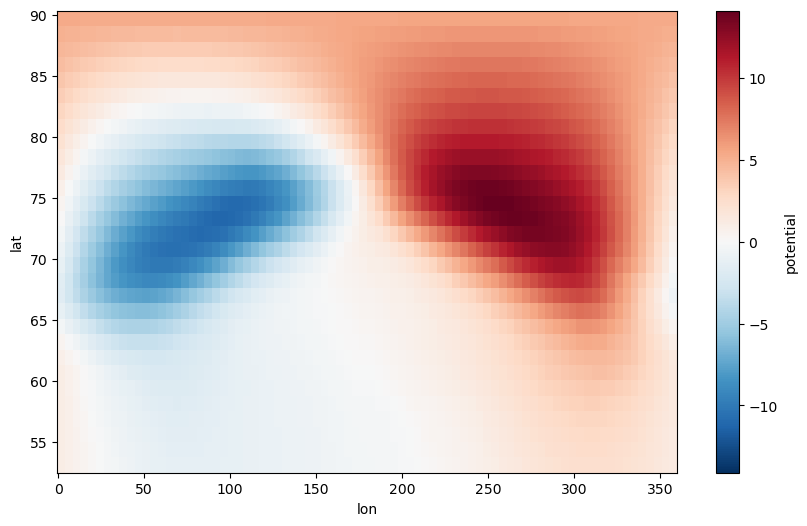

In [72]:
lat = np.linspace(53.1, 89.7, 30)
lon = np.linspace(1.6, 357.6, 80)
potential = reshaped_predicted[0]

ds_predicted = xr.Dataset({'potential': (['lat', 'lon'], potential)},
                            coords={'lat': lat, 'lon': lon})


#plotting the predicted potential
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ds_predicted['potential'].plot(ax=ax)

In [73]:
# Set the model to evaluation mode
model.eval()

# List to store the predictions
predictions = []

# Iterate through the test set
for i in range(0, len(X_test_tensor), sequence_length):
    inputs = X_test_tensor[i:i+sequence_length]
    with torch.no_grad():
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension and make prediction
    predictions.append(outputs.squeeze().numpy())  # Squeeze to remove batch dimension and convert to numpy array

# Concatenate predictions into a single array
predictions = np.concatenate(predictions, axis=0)

ValueError: range() arg 3 must not be zero

In [ ]:
predictions.reshape(-1, 30, 80).shape

(2880, 30, 80)